## This file was used for data analysis of lung data and subsetting to protein coding genes

In [83]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from pybiomart import Server
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score,  silhouette_samples
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [2]:
# Define the main folder containing all sample subfolders
input_file = "Datasets/DESeq2Input/lungCounts.csv"
sample_sheet = pd.read_csv("Datasets/DESeq2Input/lung_sample_sheet.tsv", sep='\t')
clinical = pd.read_csv("Datasets/DESeq2Input/lung_clinical.tsv", sep='\t', low_memory=False)
metadata_file = "Datasets/DESeq2Input/lungMetadata.csv"

In [3]:
df = pd.read_csv(input_file)

In [4]:
df.index = df['gene_id']
df = df.drop('gene_id', axis = 1)

In [5]:
df

5faf8a12-a2aa-44f1-b099-02106766ec94  \
gene_id                                                    
ENSG00000000003.15                                1317.0   
ENSG00000000005.6                                    1.0   
ENSG00000000419.13                                2172.0   
ENSG00000000457.14                                 738.0   
ENSG00000000460.17                                 426.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    1.0   
ENSG00000288670.1                                  219.0   
ENSG00000288674.1                                    7.0   
ENSG00000288675.1                                   10.0   

                    6855a406-c085-45c7-b789-981786f0c775  \
gene_id                                                    
ENSG00000000003.15                                7434.0   
ENSG00000000005.6                                    0.0   
ENSG00000000419.13                                2968.0   
ENSG00000000457.14                                 555.0   
ENSG00000000460.17                                 643.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    0.0   
ENSG00000288670.1                                  144.0   
ENSG00000288674.1                                    4.0   
ENSG00000288675.1                                   17.0   

                    e2445ad6-2a6a-4ec3-84d8-93cc3c180a58  \
gene_id                                                    
ENSG00000000003.15                                3037.0   
ENSG00000000005.6                                    0.0   
ENSG00000000419.13                                3243.0   
ENSG00000000457.14                                 499.0   
ENSG00000000460.17                                 980.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    0.0   
ENSG00000288670.1                                  356.0   
ENSG00000288674.1                                    2.0   
ENSG00000288675.1                                   19.0   

                    cded92df-9367-4ee5-930c-6c87bf2c8eb0  \
gene_id                                                    
ENSG00000000003.15                                1962.0   
ENSG00000000005.6                                    2.0   
ENSG00000000419.13                                2547.0   
ENSG00000000457.14                                1507.0   
ENSG00000000460.17                                1395.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    0.0   
ENSG00000288670.1                                  440.0   
ENSG00000288674.1                                    7.0   
ENSG00000288675.1                                    9.0   

                    4b167e70-e4e6-47f7-9fe9-11cf20f0d442  \
gene_id                                                    
ENSG00000000003.15                                2538.0   
ENSG00000000005.6                                    0.0   
ENSG00000000419.13                                1816.0   
ENSG00000000457.14                                 545.0   
ENSG00000000460.17                                 488.0   
...                                                  ...   
ENSG00000288667.1                                    0.0   
ENSG00000288669.1                                    0.0   
ENSG00000288670.1                                  196.0   
ENSG00000288674.1                                    3.0   
ENSG00000288675.1                                   19.0   

                    51c0568a-3e54-42a0-b805-0a90905cc865  \
gene_id                                                

## Unique Genes

In [6]:
gene_ids = df.index.to_series()

# Remove version suffix (e.g., .15)
gene_ids_stripped = gene_ids.str.replace(r'\.\d+$', '', regex=True)

# Get number of unique genes
num_unique_genes = gene_ids_stripped.nunique()

print(f"Number of unique gene IDs (version-stripped): {num_unique_genes}")

Number of unique gene IDs (version-stripped): 58122


## Get protein coding genes

In [7]:
# Connect to Ensembl
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

# Query gene info (without version)
gene_ids_stripped = pd.Series(gene_ids).str.replace(r'\.\d+$', '', regex=True)

# Get gene type info for your IDs
annotations = dataset.query(attributes=['ensembl_gene_id', 'gene_biotype'])
protein_coding_genes = annotations[annotations['Gene type'] == 'protein_coding']['Gene stable ID']

In [8]:
df_filtered =  df[df.index.str.replace(r'\.\d+$', '', regex=True).isin(protein_coding_genes)]

In [9]:
df_filtered.shape

(19541, 1162)

In [10]:
output_file = "DESeq2Local/DESeq2Input/lungFilteredGenesCounts.csv"
df_filtered.to_csv(output_file)

## Visualize Clinical data

In [11]:
# Build sample-to-case map
sample_to_case = sample_sheet[['File ID', 'Case ID']].dropna()

In [12]:
len(sample_to_case)

1162

In [13]:
sample_to_case

File ID       Case ID
0     ba8aebd8-07de-46c0-a28f-b2408c36f07f  TCGA-44-2665
1     6508912f-5f91-43e6-8e63-9233bf3e81eb  TCGA-97-7937
2     56e9a740-ee72-4c10-a90d-921034141b42  TCGA-44-2665
3     fc732523-d387-4a1d-ab81-34e44e869bac  TCGA-44-2665
4     db9bab18-a465-445f-a4fd-dc90faa1da6d  TCGA-64-5774
...                                    ...           ...
1157  a2ff795f-2f9f-4a67-a8e8-5d1b70f397d8  TCGA-39-5028
1158  5bb8ce26-770f-48cc-a481-466469d34073  TCGA-NC-A5HE
1159  c8a68cbe-87a1-44b3-bf4b-68ba0de91994  TCGA-66-2783
1160  5c3ec03d-d9eb-48e8-b132-5733dcf83131  TCGA-66-2795
1161  42afded2-aa23-4f7f-b86f-ac47b324db1d  TCGA-66-2788

[1162 rows x 2 columns]

In [14]:
# Ensure samples match those in df
sample_to_case = sample_to_case[sample_to_case['File ID'].isin(df.columns)]

In [15]:
len(sample_to_case)

1162

In [16]:
clinical_unique = clinical.drop_duplicates(subset='cases.submitter_id')

In [17]:
len(clinical)

4229

In [18]:
len(clinical_unique)

1018

In [19]:
clinical_columns_to_keep = [
    'cases.submitter_id',
    'demographic.gender',
    'demographic.age_at_index',
    'demographic.race',
    # 'demographic.vital_status',
    'cases.disease_type',
    'diagnoses.ajcc_pathologic_stage',
    'diagnoses.classification_of_tumor',
    'diagnoses.primary_diagnosis',
    #'diagnoses.tissue_or_organ_of_origin',
    #'treatments.initial_disease_status',
    #'treatments.therapeutic_agents',
    #'treatments.treatment_type',
    # 'diagnoses.ajcc_pathologic_n',
    #'diagnoses.ajcc_pathologic_t',
    #'diagnoses.ajcc_pathologic_m'
]

In [20]:
clinical_subset = clinical_unique[clinical_columns_to_keep]

In [21]:
sample_clinical = pd.merge(sample_to_case, clinical_subset,
                           left_on='Case ID',
                           right_on='cases.submitter_id',
                           how='left')

In [22]:
sample_clinical.index = sample_clinical['File ID']
sample_clinical = sample_clinical.drop('File ID', axis =1)

In [23]:
# reorder to match OG order
sample_clinical = sample_clinical.loc[df_filtered.columns.intersection(sample_clinical.index)]

In [24]:
sample_clinical

Case ID cases.submitter_id  \
5faf8a12-a2aa-44f1-b099-02106766ec94  TCGA-NC-A5HJ       TCGA-NC-A5HJ   
6855a406-c085-45c7-b789-981786f0c775  TCGA-38-4629       TCGA-38-4629   
e2445ad6-2a6a-4ec3-84d8-93cc3c180a58  TCGA-22-1012       TCGA-22-1012   
cded92df-9367-4ee5-930c-6c87bf2c8eb0  TCGA-18-5592       TCGA-18-5592   
4b167e70-e4e6-47f7-9fe9-11cf20f0d442  TCGA-39-5035       TCGA-39-5035   
...                                            ...                ...   
be7b80c8-2256-4725-a330-7435742aa309  TCGA-22-5491       TCGA-22-5491   
c36f84e5-8c59-46fe-af32-7f70684383b2  TCGA-55-6971       TCGA-55-6971   
4c994cf9-52d0-4c05-97c0-fd2d3ffb9100  TCGA-43-3394       TCGA-43-3394   
94613d97-0a68-4212-beef-3c97a0b363ef  TCGA-50-5931       TCGA-50-5931   
d1f98c65-fd27-4893-a5c5-bc0bfe16ac5f  TCGA-56-7222       TCGA-56-7222   

                                     demographic.gender  \
5faf8a12-a2aa-44f1-b099-02106766ec94               male   
6855a406-c085-45c7-b789-981786f0c775               male   
e2445ad6-2a6a-4ec3-84d8-93cc3c180a58             female   
cded92df-9367-4ee5-930c-6c87bf2c8eb0               male   
4b167e70-e4e6-47f7-9fe9-11cf20f0d442             female   
...                                                 ...   
be7b80c8-2256-4725-a330-7435742aa309               male   
c36f84e5-8c59-46fe-af32-7f70684383b2             female   
4c994cf9-52d0-4c05-97c0-fd2d3ffb9100               male   
94613d97-0a68-4212-beef-3c97a0b363ef             female   
d1f98c65-fd27-4893-a5c5-bc0bfe16ac5f               male   

                                     demographic.age_at_index  \
5faf8a12-a2aa-44f1-b099-02106766ec94                       59   
6855a406-c085-45c7-b789-981786f0c775                       68   
e2445ad6-2a6a-4ec3-84d8-93cc3c180a58                       80   
cded92df-9367-4ee5-930c-6c87bf2c8eb0                       57   
4b167e70-e4e6-47f7-9fe9-11cf20f0d442                       72   
...                                                       ...   
be7b80c8-2256-4725-a330-7435742aa309                       74   
c36f84e5-8c59-46fe-af32-7f70684383b2                       59   
4c994cf9-52d0-4c05-97c0-fd2d3ffb9100                       52   
94613d97-0a68-4212-beef-3c97a0b363ef                       75   
d1f98c65-fd27-4893-a5c5-bc0bfe16ac5f                       60   

                                               demographic.race  \
5faf8a12-a2aa-44f1-b099-02106766ec94                      white   
6855a406-c085-45c7-b789-981786f0c775                      white   
e2445ad6-2a6a-4ec3-84d8-93cc3c180a58                      white   
cded92df-9367-4ee5-930c-6c87bf2c8eb0               not reported   
4b167e70-e4e6-47f7-9fe9-11cf20f0d442                      white   
...                                                         ...   
be7b80c8-2256-4725-a330-7435742aa309                      white   
c36f84e5-8c59-46fe-af32-7f70684383b2                      white   
4c994cf9-52d0-4c05-97c0-fd2d3ffb9100  black or african american   
94613d97-0a68-4212-beef-3c97a0b363ef                      white   
d1f98c65-fd27-4893-a5c5-bc0bfe16ac5f                      white   

                                                cases.disease_type  \
5faf8a12-a2aa-44f1-b099-02106766ec94       Squamous Cell Neoplasms   
6855a406-c085-45c7-b789-981786f0c775  Adenomas and Adenocarcinomas   
e2445ad6-2a6a-4ec3-84d8-93cc3c180a58       Squamous Cell Neoplasms   
cded92df-9367-4ee5-930c-6c87bf2c8eb0       Squamous Cell Neoplasms   
4b167e70-e4e6-47f7-9fe9-11cf20f0d442       Squamous Cell Neoplasms   
...                                                            ...   
be7b80c8-2256-4725-a330-7435742aa309       Squamous Cell Neoplasms   
c36f84e5-8c59-46fe-af32-7f70684383b2  Adenomas and Adenocarcinomas   
4c994cf9-52d0-4c05-97c0-fd2d3ffb9100       Squamous Cell Neoplasms   
94613d97-0a68-4212-beef-3c97a0b363ef  Adenomas and Adenocarcinomas   
d1f98c65-fd27-4893-a5c5-bc0bfe16ac5f       Squamous Cell Neoplasms   

                              

In [148]:
sample_clinical_file = "Datasets/DESeq2Input/lungSampleToClinicalFeatures.csv"
sample_clinical.to_csv(sample_clinical_file)

In [25]:
clinical_disease_columns = [
    # 'demographic.vital_status',
    'cases.disease_type',
    'diagnoses.ajcc_pathologic_stage',
    'diagnoses.classification_of_tumor',
    'diagnoses.primary_diagnosis',
    #'diagnoses.tissue_or_organ_of_origin',
    #'treatments.initial_disease_status',
    #'treatments.therapeutic_agents',
    #'treatments.treatment_type',
    # 'diagnoses.ajcc_pathologic_n',
    #'diagnoses.ajcc_pathologic_t',
    #'diagnoses.ajcc_pathologic_m'
]

In [26]:
metadata_df = pd.read_csv(metadata_file)

In [27]:
normal_samples = metadata_df.loc[metadata_df['condition'] == "normal", 'sample_id']

In [28]:
normal_samples

1052    29dd3ad7-f2c6-4abf-8e81-6734e4bd8a6a
1053    a4b8b2f2-6a56-4999-bd95-c2c8e4aa3bd0
1054    661b6fed-d56a-452b-adaa-4b48ee9f4dbb
1055    1a06f92b-21c5-4666-b666-8b9135a4482a
1056    94913b2f-256e-4487-90ed-2c9b3869ca6b
                        ...                 
1157    be7b80c8-2256-4725-a330-7435742aa309
1158    c36f84e5-8c59-46fe-af32-7f70684383b2
1159    4c994cf9-52d0-4c05-97c0-fd2d3ffb9100
1160    94613d97-0a68-4212-beef-3c97a0b363ef
1161    d1f98c65-fd27-4893-a5c5-bc0bfe16ac5f
Name: sample_id, Length: 110, dtype: object

In [29]:
for col in clinical_disease_columns:
    sample_clinical.loc[normal_samples, col] = "NA/Normal Sample"

In [30]:
columns_to_group = [
    'demographic.gender',
    'demographic.age_at_index',
    'demographic.race',
    'cases.disease_type',
    'diagnoses.ajcc_pathologic_stage',
    'diagnoses.classification_of_tumor',
    'diagnoses.primary_diagnosis',
]

In [31]:
columns_to_group_dict = {
    'Gender' : 'demographic.gender',
    'Age': 'demographic.age_at_index',
    'Race': 'demographic.race',
    'Disease Type' : 'cases.disease_type',
    'Pathologic Stage': 'diagnoses.ajcc_pathologic_stage',
    'Classification of Tumor' :'diagnoses.classification_of_tumor',
    'Primary Diagnosis': 'diagnoses.primary_diagnosis',
}

In [32]:
for column in columns_to_group:
    categories = sample_clinical[column].unique()
    print("Considered Column", column)
    for cat in categories:
        print(cat, len(sample_clinical[sample_clinical[column]==cat]))

Considered Column demographic.gender
male 691
female 471
Considered Column demographic.age_at_index
59 42
68 44
80 13
57 24
72 44
61 39
70 61
66 39
55 19
52 21
69 44
63 34
67 44
76 35
75 40
73 51
58 28
51 13
74 49
78 19
79 18
60 46
65 45
48 5
56 25
84 11
53 12
62 35
49 8
54 14
44 3
77 28
81 22
71 42
64 41
46 4
'-- 28
43 3
82 4
83 9
85 7
50 7
47 8
41 5
33 2
42 6
45 9
86 2
87 2
89 1
38 1
40 3
39 2
88 1
Considered Column demographic.race
white 866
not reported 178
Unknown 6
black or african american 94
asian 17
american indian or alaska native 1
Considered Column cases.disease_type
Squamous Cell Neoplasms 510
Adenomas and Adenocarcinomas 498
Acinar Cell Neoplasms 24
Cystic, Mucinous and Serous Neoplasms 17
Ductal and Lobular Neoplasms 3
NA/Normal Sample 110
Considered Column diagnoses.ajcc_pathologic_stage
Stage IIB 134
Stage IB 248
Stage IA 187
'-- 217
Stage IV 27
Stage IIIA 98
Stage IIIB 26
Stage III 3
Stage IIA 98
Stage II 4
Stage I 10
NA/Normal Sample 110
Considered Column diagnoses.c

In [34]:
age_data = []
categories = sample_clinical[columns_to_group_dict['Age']].unique()
for cat in categories:
    age_data.append((cat, len(sample_clinical[sample_clinical[columns_to_group_dict['Age']]==cat])))

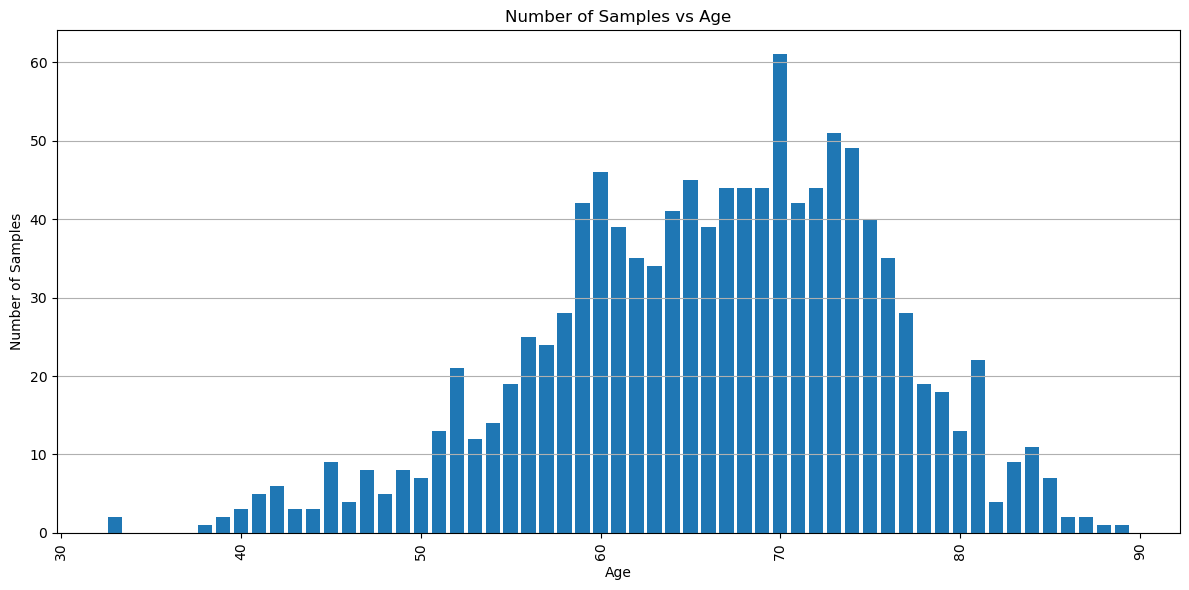

In [35]:
age_df = pd.DataFrame(age_data, columns=["Age", "Count"])

# Convert Age to numeric, setting errors='coerce' to handle '--'
age_df["Age"] = pd.to_numeric(age_df["Age"], errors='coerce')

# Drop rows with NaN Age (i.e., '--')
age_df = age_df.dropna(subset=["Age"])

age_df = age_df.sort_values("Age")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(age_df["Age"], age_df["Count"])
plt.xlabel("Age")
plt.ylabel("Number of Samples")
plt.title("Number of Samples vs Age")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

### UMAP

In [59]:
adata = ad.AnnData(df_filtered.T)  # Transpose: cells x genes

In [60]:
adata

AnnData object with n_obs × n_vars = 1162 × 19541

In [61]:
for col in columns_to_group:
   adata.obs[col] = sample_clinical[col].copy()

In [63]:
ages = sample_clinical[columns_to_group_dict['Age']]
ages_cleaned = pd.to_numeric(ages, errors='coerce')
adata.obs['Continuous Age'] = ages_cleaned.values

In [64]:
sc.pp.log1p(adata)

sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

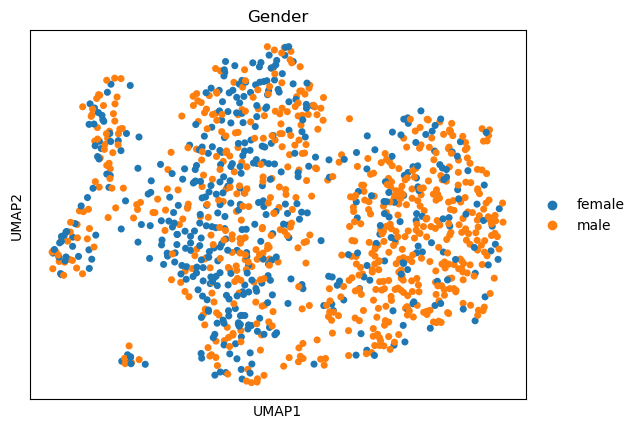

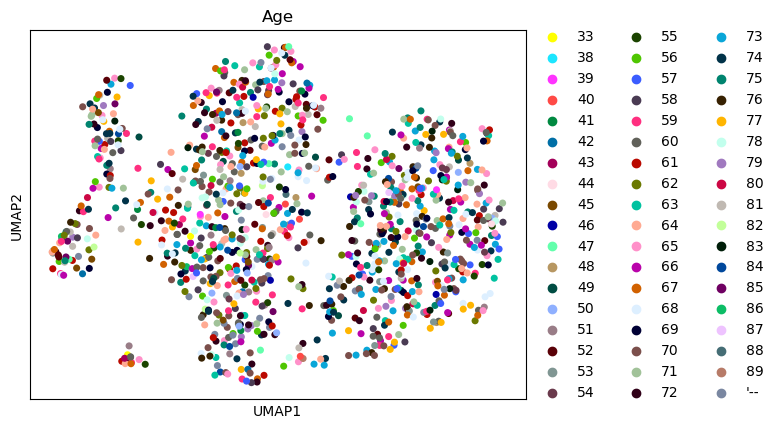

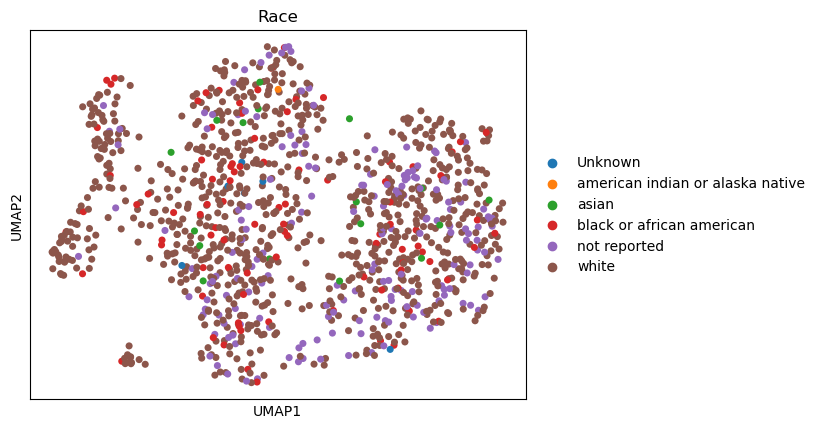

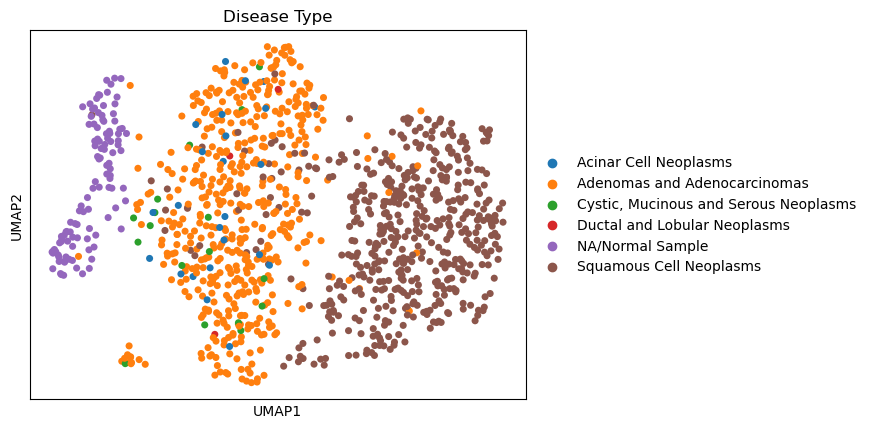

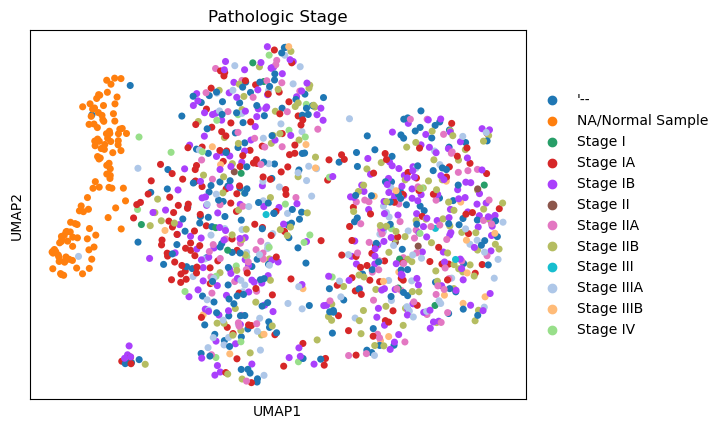

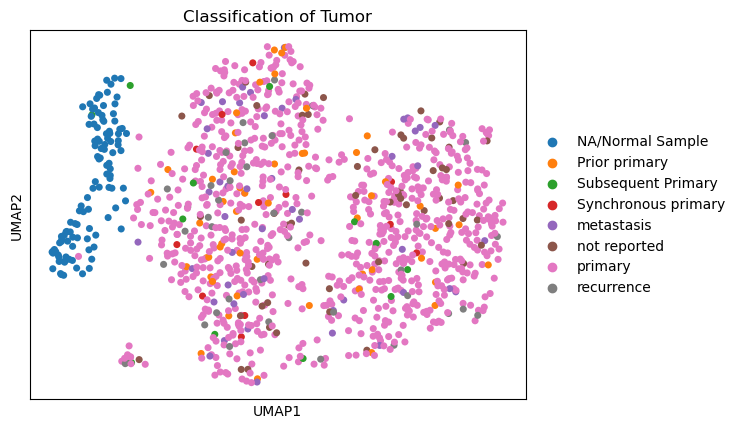

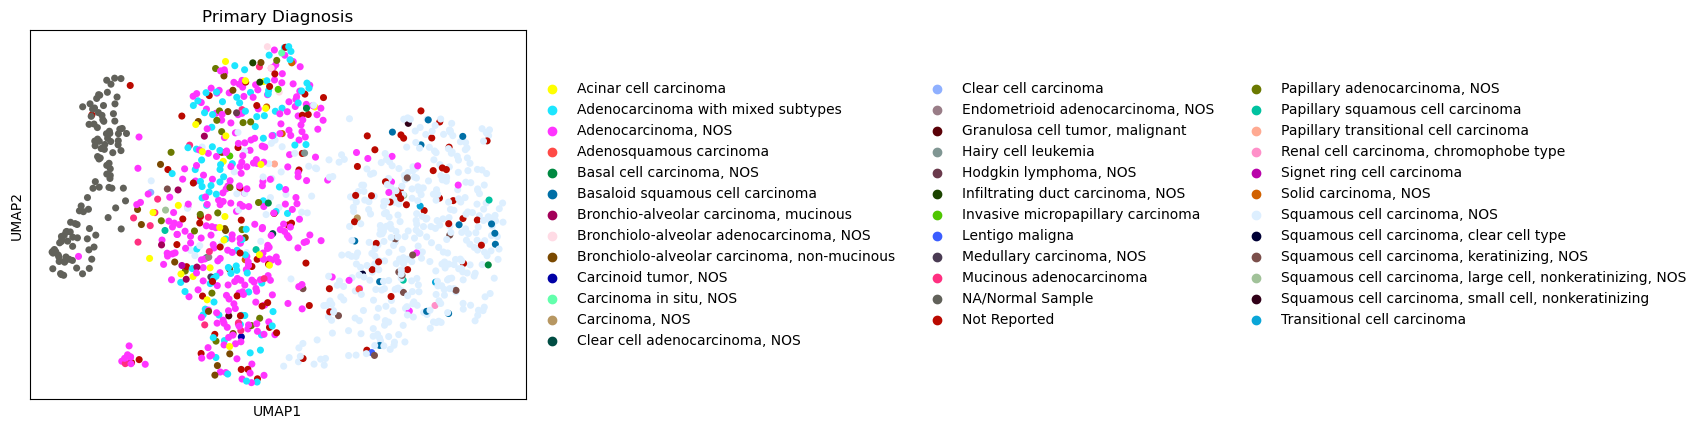

In [65]:
for key in columns_to_group_dict:
    sc.pl.umap(adata, color=columns_to_group_dict[key], title=key, save=f"_{key.replace(' ', '_')}.png")

In [66]:
stage_to_num = {
    '--':     np.nan,
    'NA/Normal Sample':  -1,
    'Stage I':    1.0,
    'Stage IA':   1.1,
    'Stage IB':   1.2,
    'Stage II':   2.0,
    'Stage IIA':  2.1,
    'Stage IIB':  2.2,
    'Stage III':  3.0,
    'Stage IIIA': 3.1,
    'Stage IIIB': 3.2,
    'Stage IV':   4.0
}

# Apply to adata.obs
path_key = "pathologic_stage_numeric"
adata.obs[path_key] = adata.obs["diagnoses.ajcc_pathologic_stage"].map(stage_to_num)

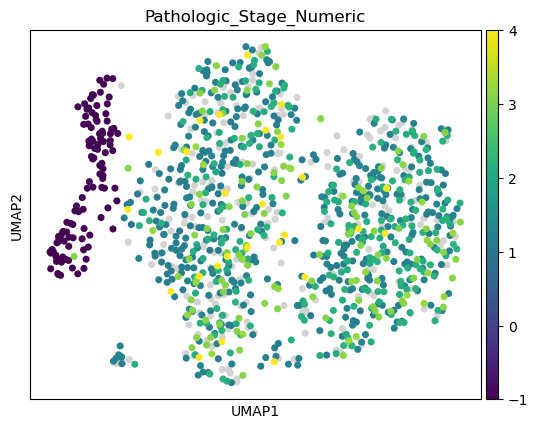

In [72]:
sc.pl.umap(adata, color=path_key, title='Pathologic_Stage_Numeric', save=f"_{path_key.replace(' ', '_')}.png")

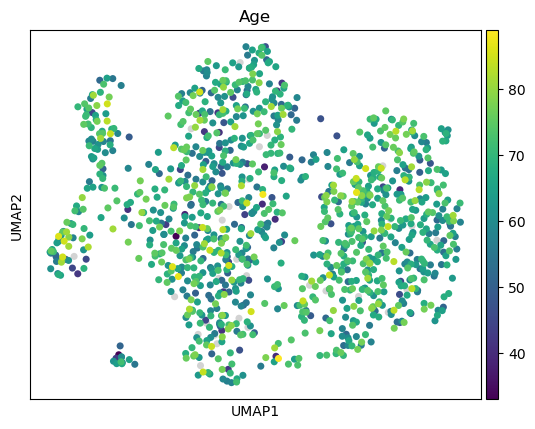

In [71]:
sc.pl.umap(adata, color='Continuous Age', title='Age', save=f"_{'age'.replace(' ', '_')}.png")

In [85]:
def plot_silhouette(sil_df):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=sil_df, x='label', y='silhouette', hue='label', palette='Set2', legend=False)
    plt.axhline(0, linestyle='--', color='gray')
    plt.title("Silhouette scores by condition/subtype")
    plt.ylabel("Silhouette value")
    plt.xlabel("Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [87]:
# Silhouette scores
umap_coords = adata.obsm['X_umap']
# Compute silhouette score
for key in columns_to_group_dict:
    labels = adata.obs[columns_to_group_dict[key]] 
    score = silhouette_score(umap_coords, labels)
    print(f"Silhouette score for UMAP with {key} labels: {score:.3f}")

Silhouette score for UMAP with Gender labels: 0.044
Silhouette score for UMAP with Age labels: -0.475
Silhouette score for UMAP with Race labels: -0.292
Silhouette score for UMAP with Disease Type labels: 0.161
Silhouette score for UMAP with Pathologic Stage labels: -0.167
Silhouette score for UMAP with Classification of Tumor labels: -0.064
Silhouette score for UMAP with Primary Diagnosis labels: -0.606


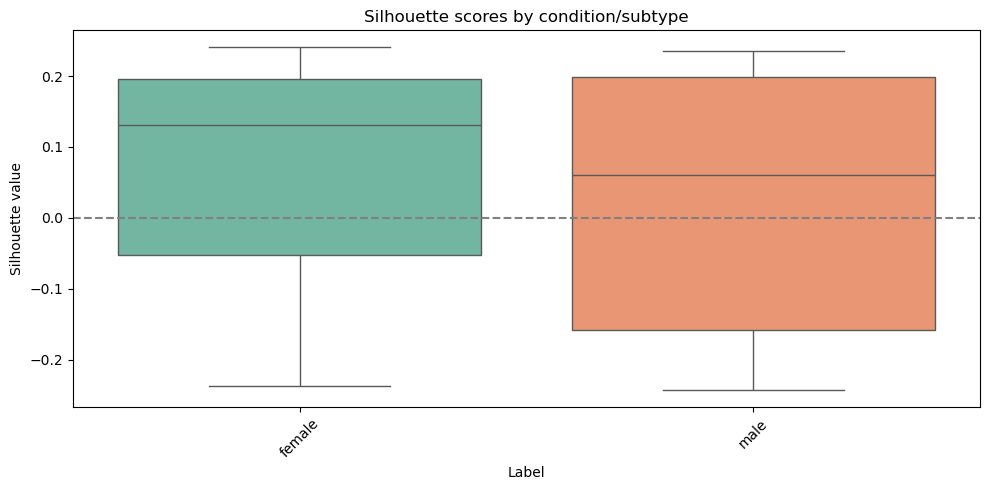

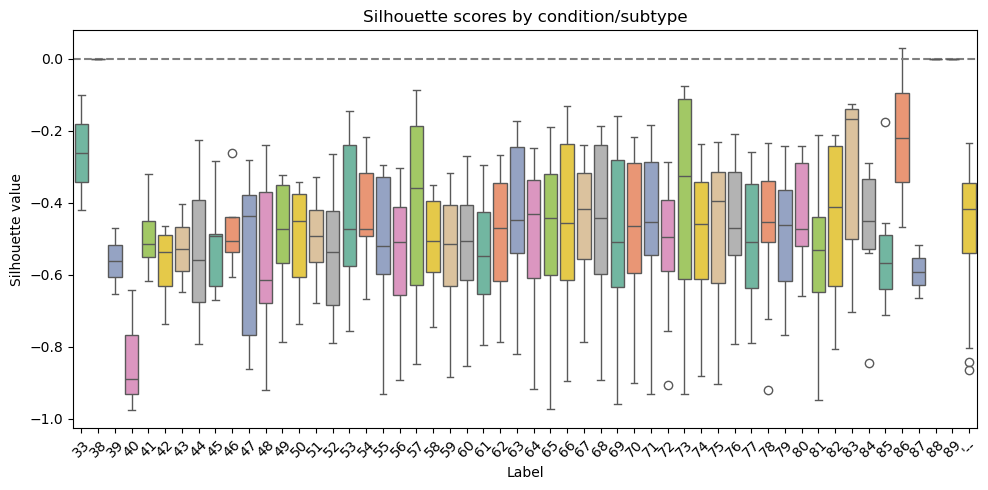

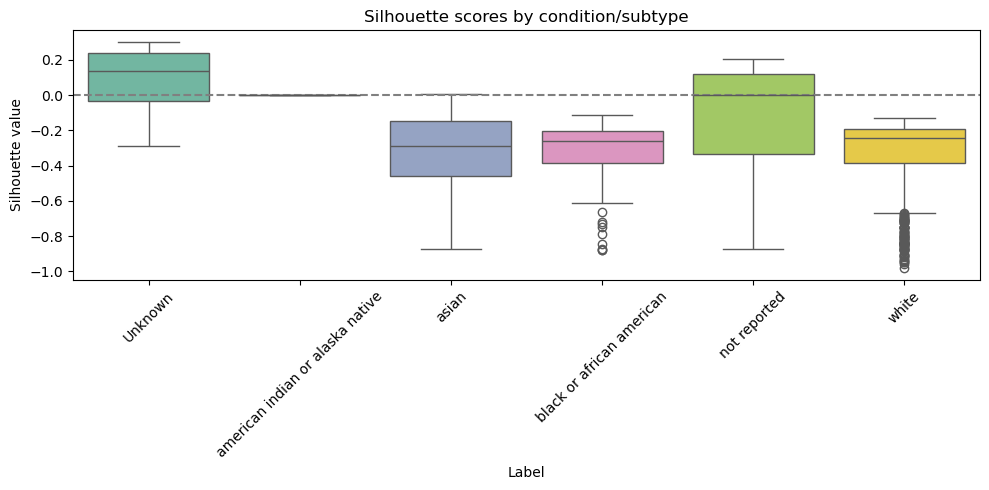

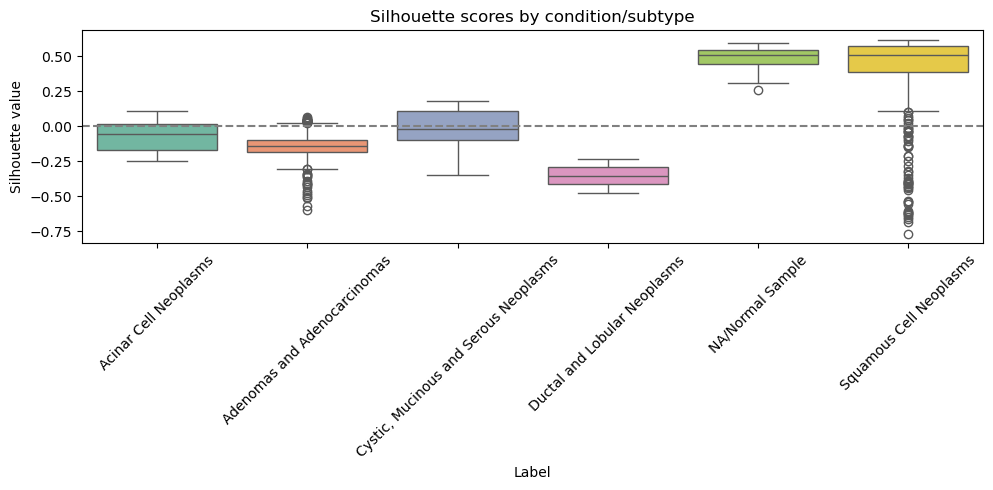

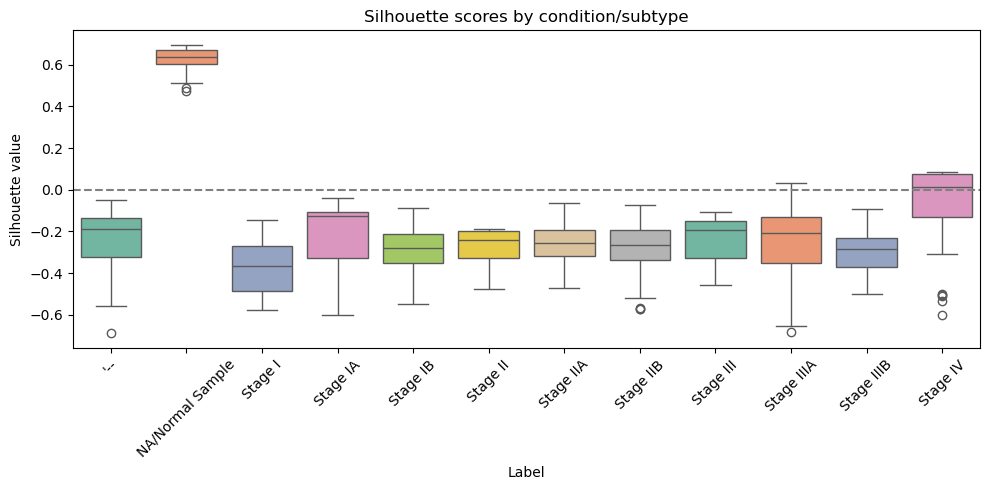

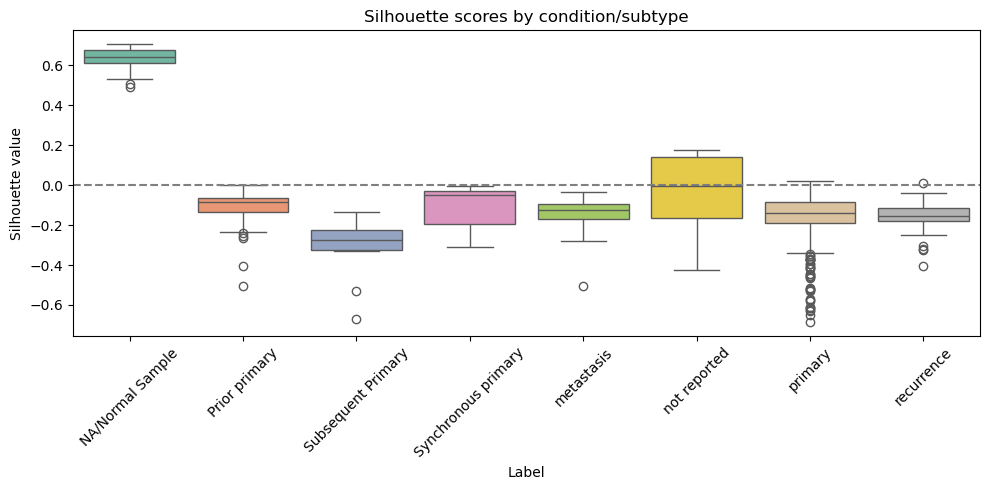

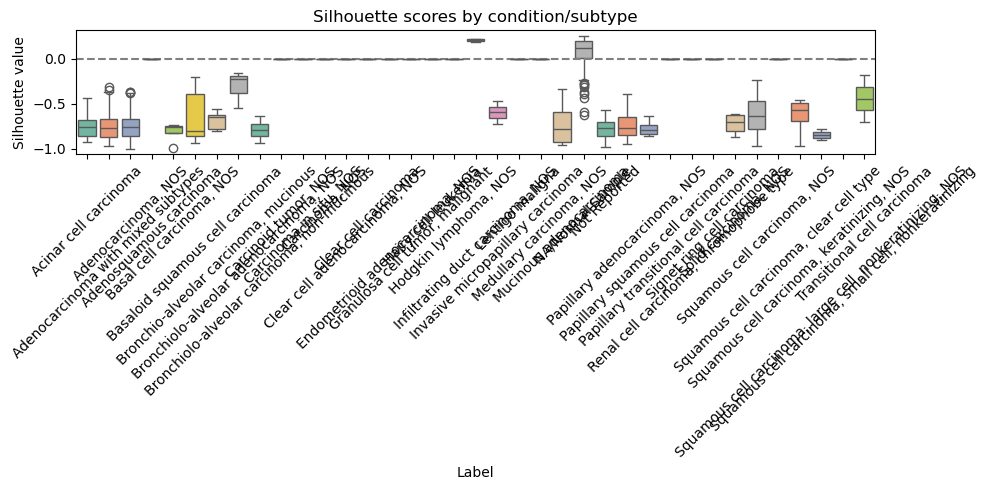

In [88]:
# Silhouette Samples
umap_coords = adata.obsm['X_umap']
# Compute silhouette score
for key in columns_to_group_dict:
    labels = adata.obs[columns_to_group_dict[key]] 
    sil_values = silhouette_samples(umap_coords, labels)
    sil_df = pd.DataFrame({
    'silhouette': sil_values,
    'label': labels.values
    })
    plot_silhouette(sil_df)

### PCA

In [ ]:
def save_pca_plot(pca_df, explained, hue, title, filename, save = True):
    plt.figure(figsize=(8, 6))
    scatter = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=hue, palette='Set2', s=60)
    plt.xlabel(f"PC1 ({explained[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({explained[1]*100:.1f}% var)")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    box = scatter.get_position()
    scatter.set_position([box.x0, box.y0, box.width * 0.8, box.height])  # Shrink plot
    plt.legend(
        title='Categories',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0.,
        ncol=2,  # Two-column legend
        fontsize='small',
        title_fontsize='medium'
    )
    if save: 
        plt.savefig(filename, dpi=300)
    plt.show()
    plt.close()

### All genes

In [71]:
df_for_pca_all = df.T
log_norm_df_all = np.log2(df_for_pca_all + 1)

In [72]:
pca = PCA(n_components=2)
pca_result_all = pca.fit_transform(log_norm_df_all)

# Put result in a DataFrame
pca_df_all = pd.DataFrame(data=pca_result_all, columns=['PC1', 'PC2'])
for key in columns_to_group_dict:
    pca_df_all[key] = list(sample_clinical[columns_to_group_dict[key]])

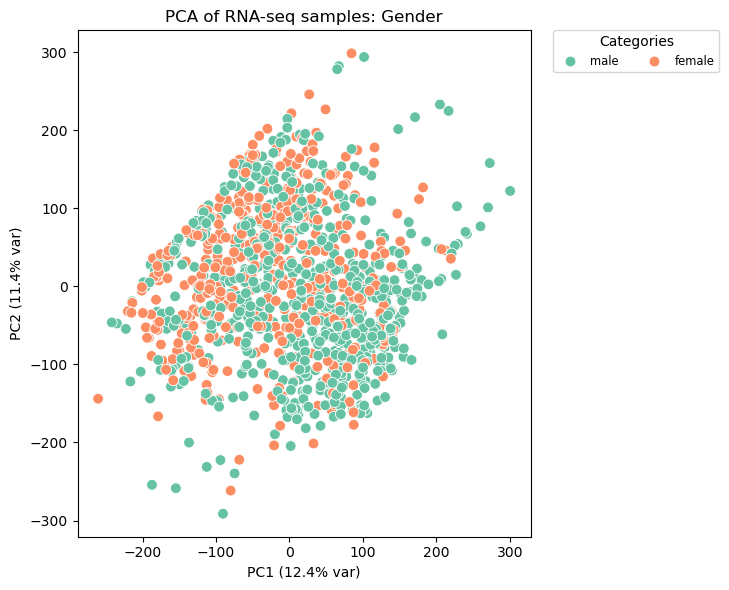

/var/folders/c4/570ty6gd42v42mmcqq8z2mrc0000gn/T/ipykernel_99869/4178465455.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


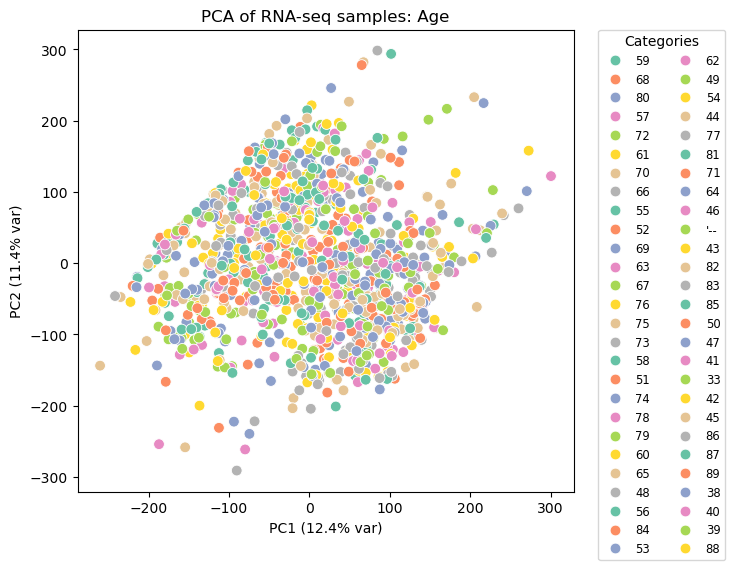

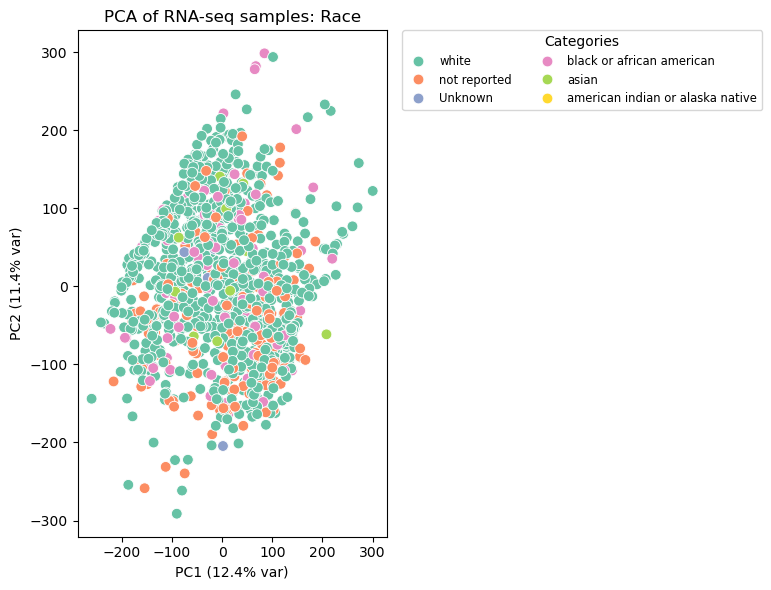

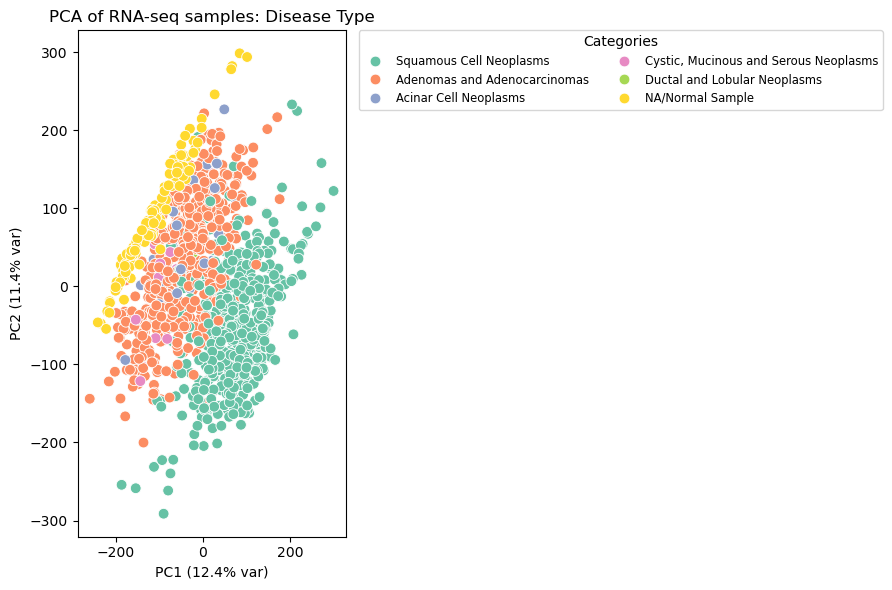

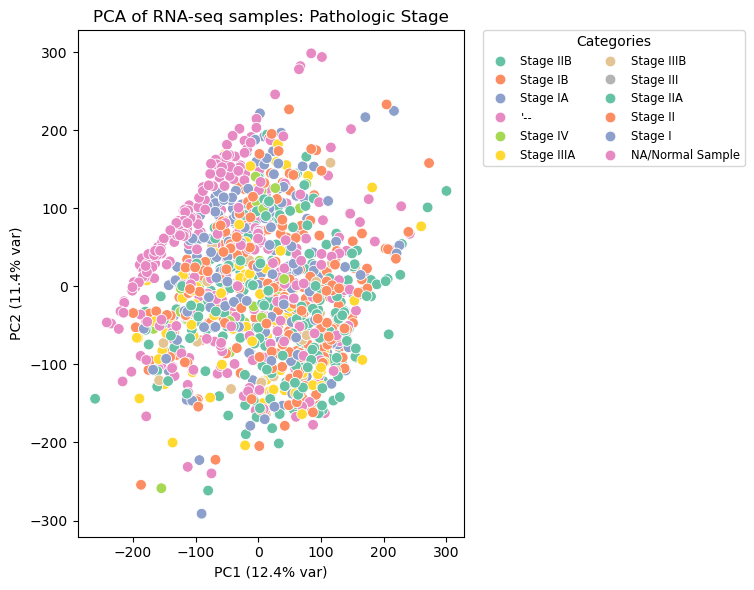

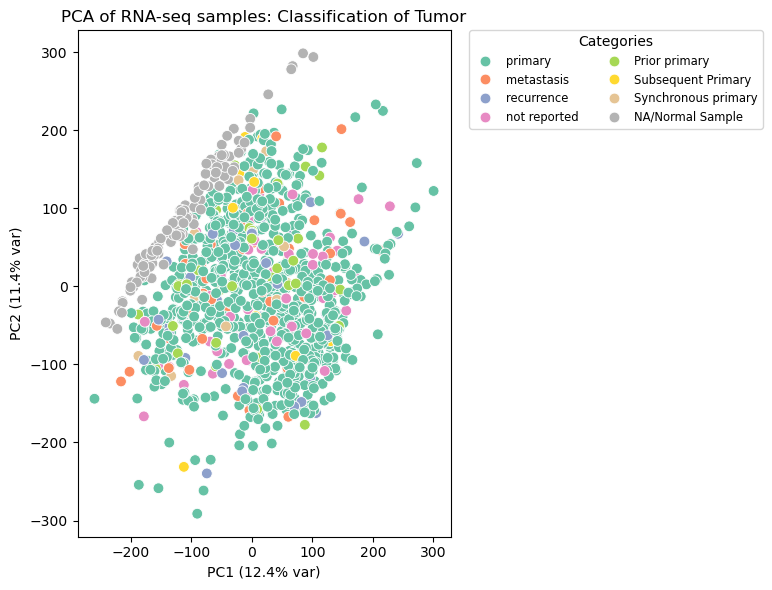

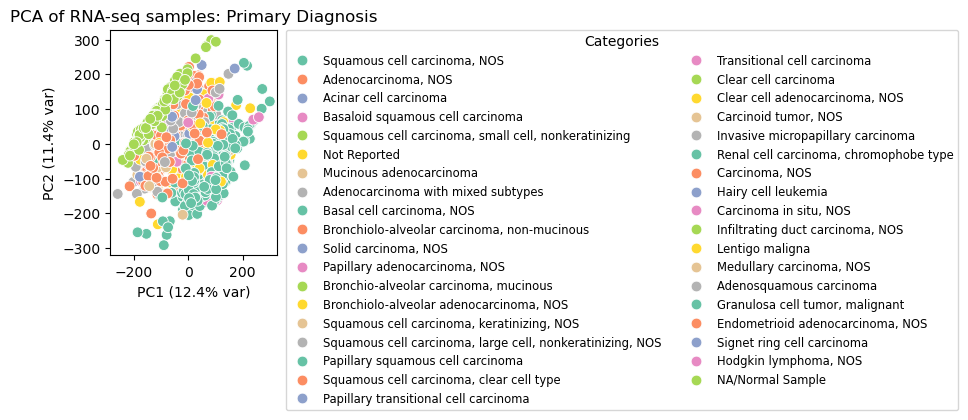

In [73]:
for key in columns_to_group_dict:
    save_pca_plot(pca_df_all, pca.explained_variance_ratio_, key,f"PCA of RNA-seq samples: {key}", f"pca_{columns_to_group_dict[key].replace(' ', '_')}.png", save = False)

In [79]:
ages = sample_clinical[columns_to_group_dict['Age']]
ages_cleaned = pd.to_numeric(ages, errors='coerce')
contAgeKey = 'Continuous Age'
pca_df_all[contAgeKey] = ages_cleaned.values

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


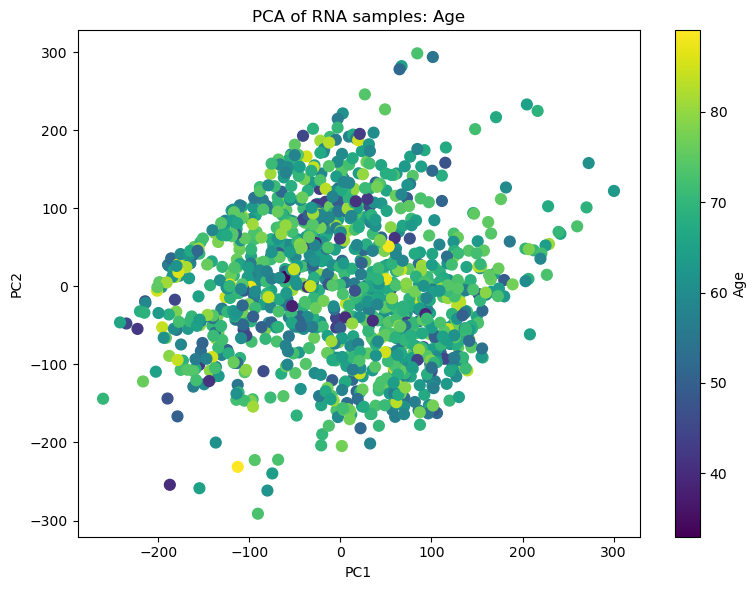

In [80]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_df_all['PC1'], pca_df_all['PC2'],
    c=pca_df_all[contAgeKey],
    cmap='viridis',
    s=60
)
plt.colorbar(scatter, label="Age")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of RNA samples: Age")
plt.savefig("pca_age.png", dpi=300)
plt.tight_layout()
plt.show()

In [81]:
stage_to_num = {
    '--':     np.nan,
    'NA/Normal Sample':  -1,
    'Stage I':    1.0,
    'Stage IA':   1.1,
    'Stage IB':   1.2,
    'Stage II':   2.0,
    'Stage IIA':  2.1,
    'Stage IIB':  2.2,
    'Stage III':  3.0,
    'Stage IIIA': 3.1,
    'Stage IIIB': 3.2,
    'Stage IV':   4.0
}
cont_stage_key = "Continuous Stage"
pca_df_all[cont_stage_key] = ages_cleaned.values
# Apply to adata.obs
path_key = "pathologic_stage_numeric"
pca_df_all[path_key] = pca_df_all["Pathologic Stage"].map(stage_to_num)

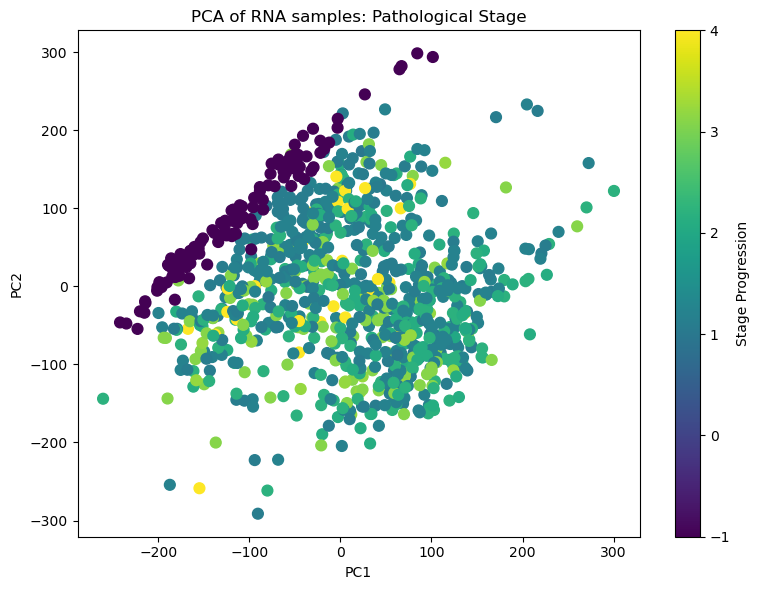

In [82]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_df_all['PC1'], pca_df_all['PC2'],
    c=pca_df_all[path_key],
    cmap='viridis',
    s=60
)
plt.colorbar(scatter, label="Stage Progression")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of RNA samples: Pathological Stage")
plt.savefig("pca_path_stage_cont.png", dpi=300)
plt.tight_layout()
plt.show()

In [78]:
X = PCA(n_components=10).fit_transform(log_norm_df_all)
#labels = sample_conditions 
for key in columns_to_group_dict:
    labels = sample_clinical[columns_to_group_dict[key]]
    score = silhouette_score(X, labels)
    print(f"Silhouette Score of Labelling {key}: {score:.3f}")

Silhouette Score of Labelling Gender: 0.026
Silhouette Score of Labelling Age: -0.298
Silhouette Score of Labelling Race: -0.174
Silhouette Score of Labelling Disease Type: 0.075
Silhouette Score of Labelling Pathologic Stage: -0.116
Silhouette Score of Labelling Classification of Tumor: -0.032
Silhouette Score of Labelling Primary Diagnosis: -0.355


### Filtered genes

In [62]:
df_for_pca = df_filtered.T
log_norm_df = np.log2(df_for_pca + 1)
# variances = log_norm_df.var(axis=0)
# top_genes = variances.sort_values(ascending=False).head(1000).index
# log_norm_df = log_norm_df[top_genes]

In [63]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_norm_df)

# Put result in a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
for key in columns_to_group_dict:
    pca_df[key] = list(sample_clinical[columns_to_group_dict[key]])

In [64]:
pca_df

PC1         PC2  Gender Age                       Race  \
0     -35.210931   40.188921    male  59                      white   
1       8.995023   38.159053    male  68                      white   
2      85.764808  -66.591952  female  80                      white   
3     123.825760  -51.961962    male  57               not reported   
4      24.911777  -56.513160  female  72                      white   
...          ...         ...     ...  ..                        ...   
1157  -92.560597  102.325436    male  74                      white   
1158 -130.750086   -0.353761  female  59                      white   
1159  -18.350965  253.465994    male  52  black or african american   
1160 -151.857007  -34.785428  female  75                      white   
1161  -96.213369   75.815930    male  60                      white   

                      Disease Type  Pathologic Stage Classification of Tumor  \
0          Squamous Cell Neoplasms         Stage IIB                 primary   
1     Adenomas and Adenocarcinomas         Stage IIB                 primary   
2          Squamous Cell Neoplasms          Stage IB                 primary   
3          Squamous Cell Neoplasms         Stage IIB                 primary   
4          Squamous Cell Neoplasms          Stage IA                 primary   
...                            ...               ...                     ...   
1157              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   
1158              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   
1159              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   
1160              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   
1161              NA/Normal Sample  NA/Normal Sample        NA/Normal Sample   

                 Primary Diagnosis  
0     Squamous cell carcinoma, NOS  
1              Adenocarcinoma, NOS  
2     Squamous cell carcinoma, NOS  
3     Squamous cell carcinoma, NOS  
4     Squamous cell carcinoma, NOS  
...                            ...  
1157              NA/Normal Sample  
1158              NA/Normal Sample  
1159              NA/Normal Sample  
1160              NA/Normal Sample  
1161              NA/Normal Sample  

[1162 rows x 9 columns]

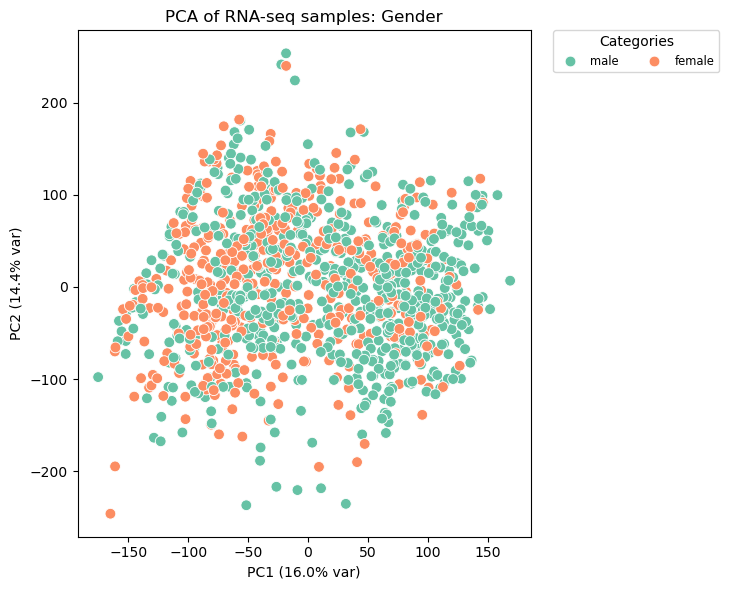

/var/folders/c4/570ty6gd42v42mmcqq8z2mrc0000gn/T/ipykernel_99869/4178465455.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


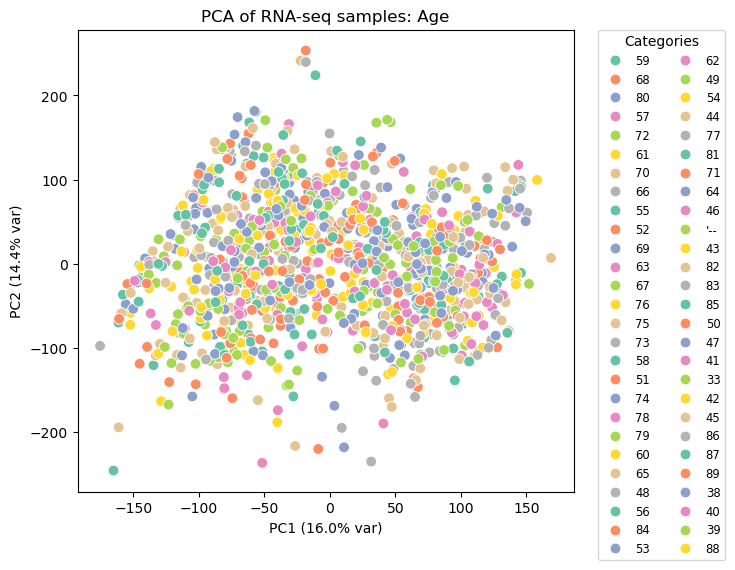

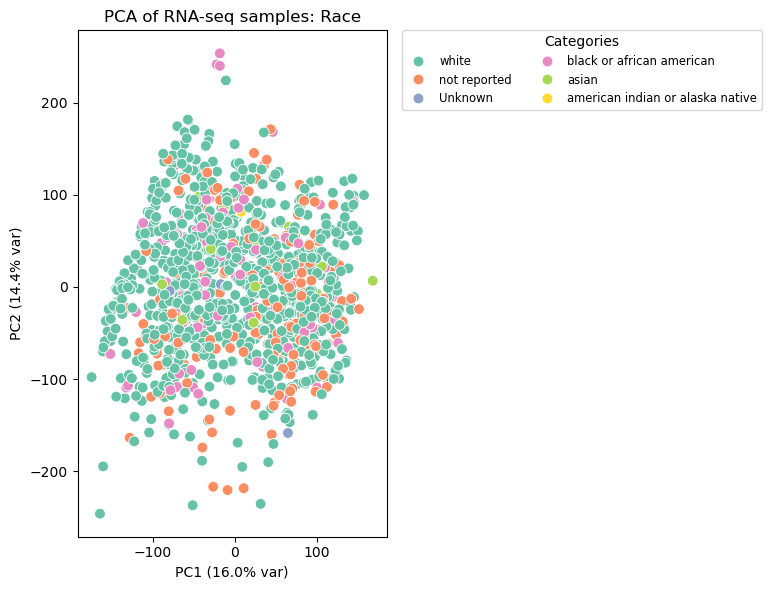

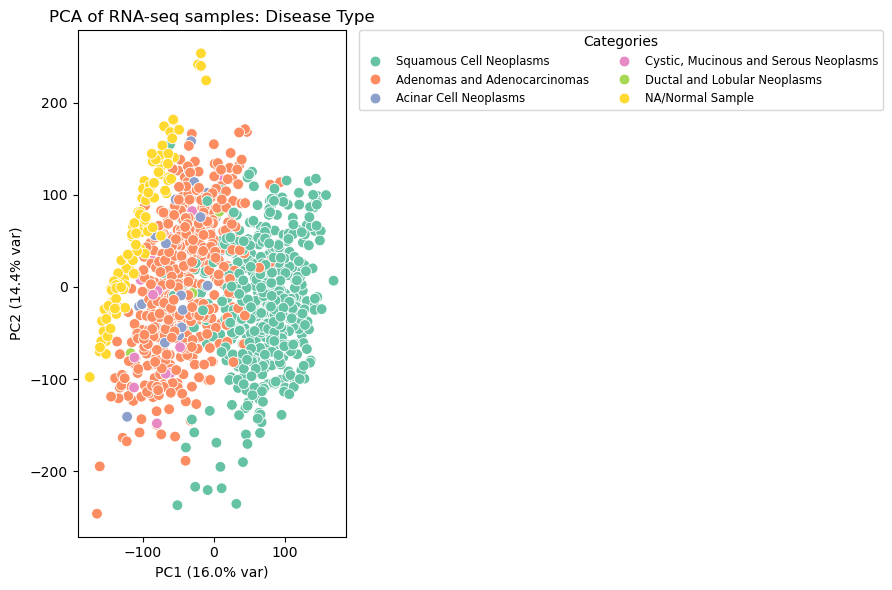

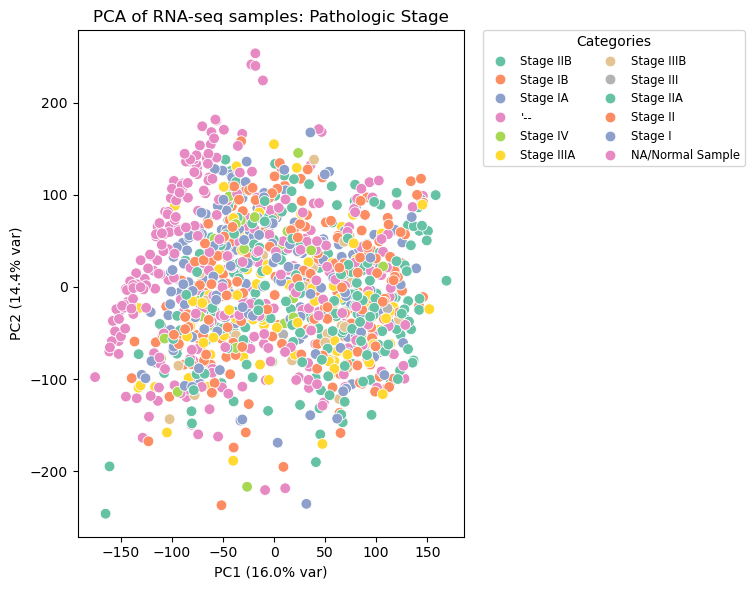

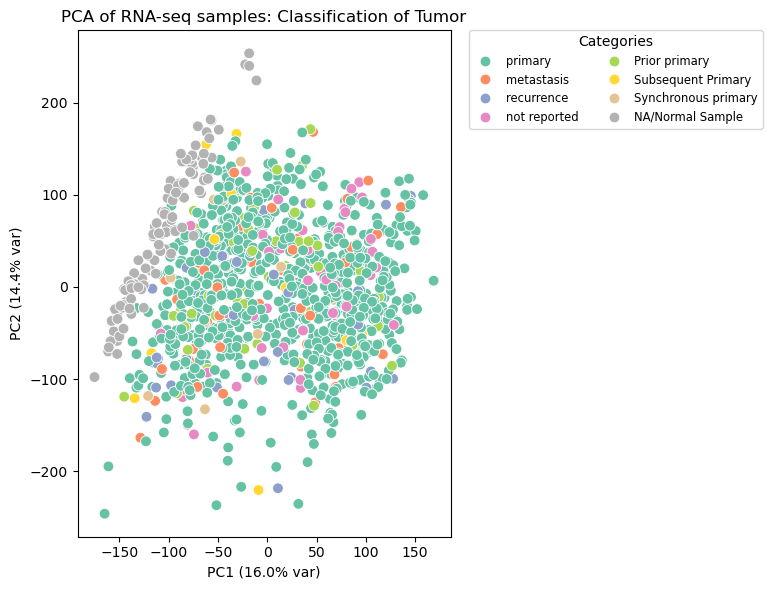

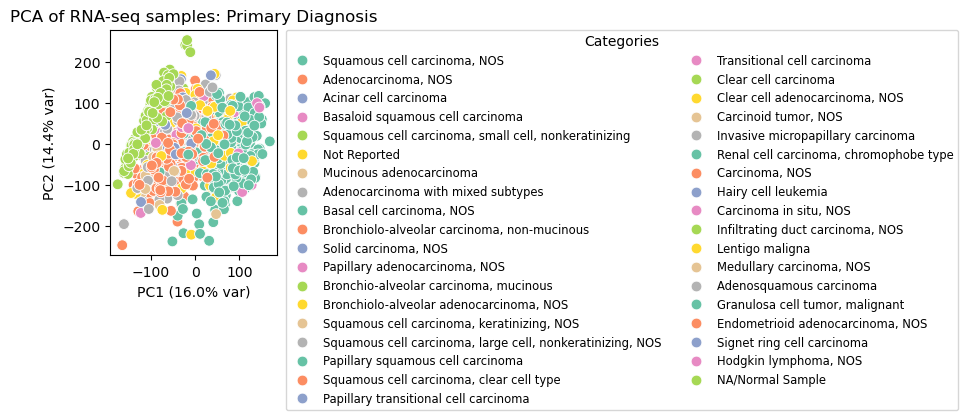

In [65]:
for key in columns_to_group_dict:
    save_pca_plot(pca_df, pca.explained_variance_ratio_, key,f"PCA of RNA-seq samples: {key}", f"pca_{columns_to_group_dict[key].replace(' ', '_')}.png", save = False)

In [66]:
ages = sample_clinical[columns_to_group_dict['Age']]
ages_cleaned = pd.to_numeric(ages, errors='coerce')
contAgeKey = 'Continuous Age'
pca_df[contAgeKey] = ages_cleaned.values

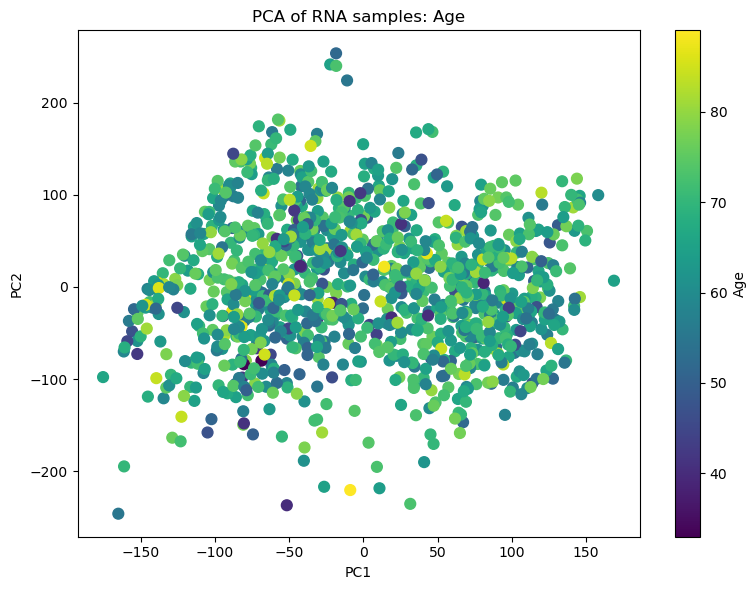

In [67]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df[contAgeKey],
    cmap='viridis',
    s=60
)
plt.colorbar(scatter, label="Age")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of RNA samples: Age")
plt.savefig("pca_age.png", dpi=300)
plt.tight_layout()
plt.show()

In [68]:
stage_to_num = {
    '--':     np.nan,
    'NA/Normal Sample':  -1,
    'Stage I':    1.0,
    'Stage IA':   1.1,
    'Stage IB':   1.2,
    'Stage II':   2.0,
    'Stage IIA':  2.1,
    'Stage IIB':  2.2,
    'Stage III':  3.0,
    'Stage IIIA': 3.1,
    'Stage IIIB': 3.2,
    'Stage IV':   4.0
}
cont_stage_key = "Continuous Stage"
pca_df[cont_stage_key] = ages_cleaned.values
# Apply to adata.obs
path_key = "pathologic_stage_numeric"
pca_df[path_key] = pca_df["Pathologic Stage"].map(stage_to_num)

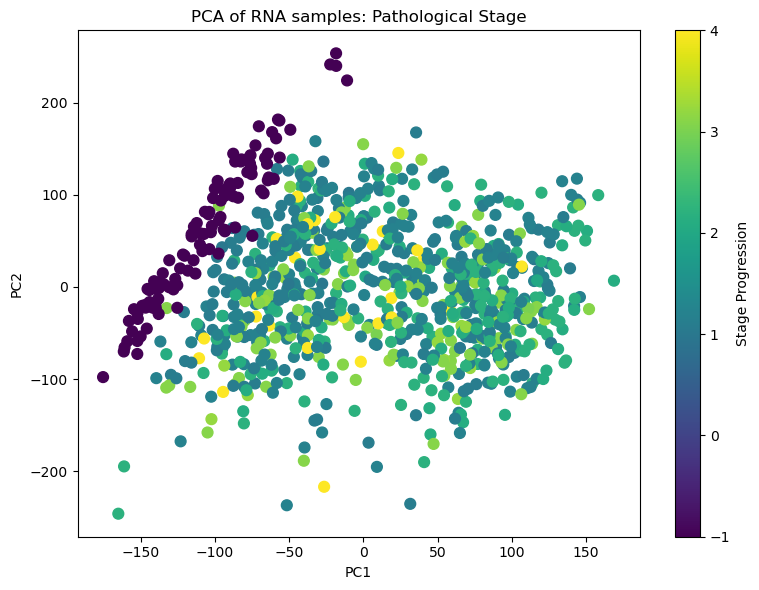

In [69]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df[path_key],
    cmap='viridis',
    s=60
)
plt.colorbar(scatter, label="Stage Progression")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA of RNA samples: Pathological Stage")
plt.savefig("pca_path_stage_cont.png", dpi=300)
plt.tight_layout()
plt.show()

### Silhouette Scores

In [70]:
X = PCA(n_components=10).fit_transform(log_norm_df)
#labels = sample_conditions 
for key in columns_to_group_dict:
    labels = sample_clinical[columns_to_group_dict[key]]
    score = silhouette_score(X, labels)
    print(f"Silhouette Score of Labelling {key}: {score:.3f}")

Silhouette Score of Labelling Gender: 0.029
Silhouette Score of Labelling Age: -0.274
Silhouette Score of Labelling Race: -0.155
Silhouette Score of Labelling Disease Type: 0.094
Silhouette Score of Labelling Pathologic Stage: -0.116
Silhouette Score of Labelling Classification of Tumor: -0.026
Silhouette Score of Labelling Primary Diagnosis: -0.350


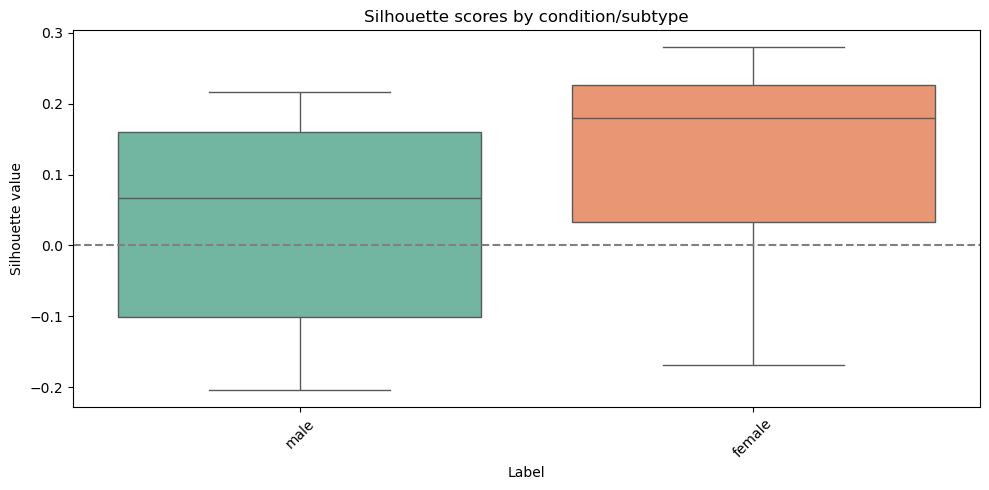

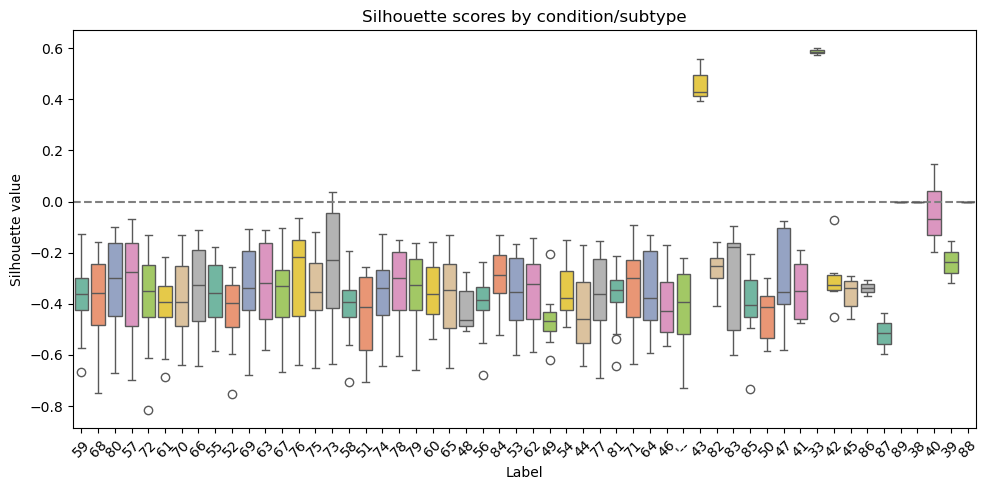

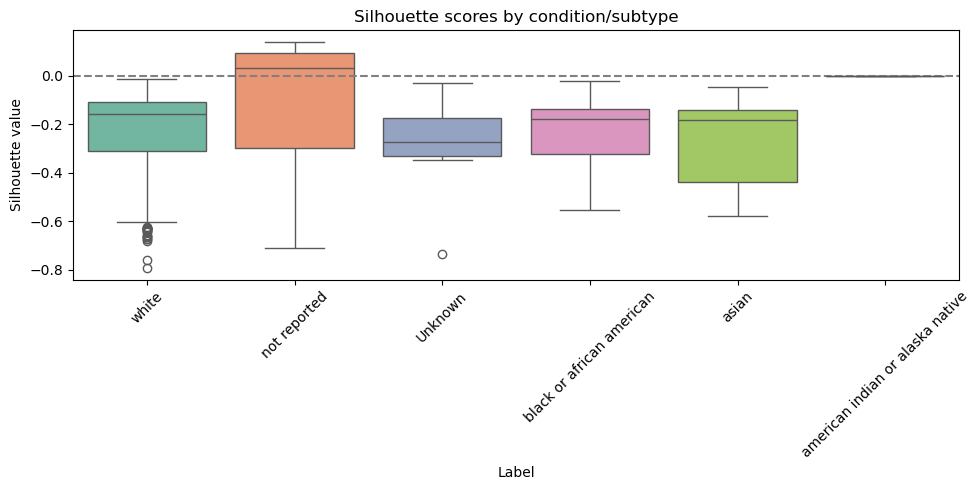

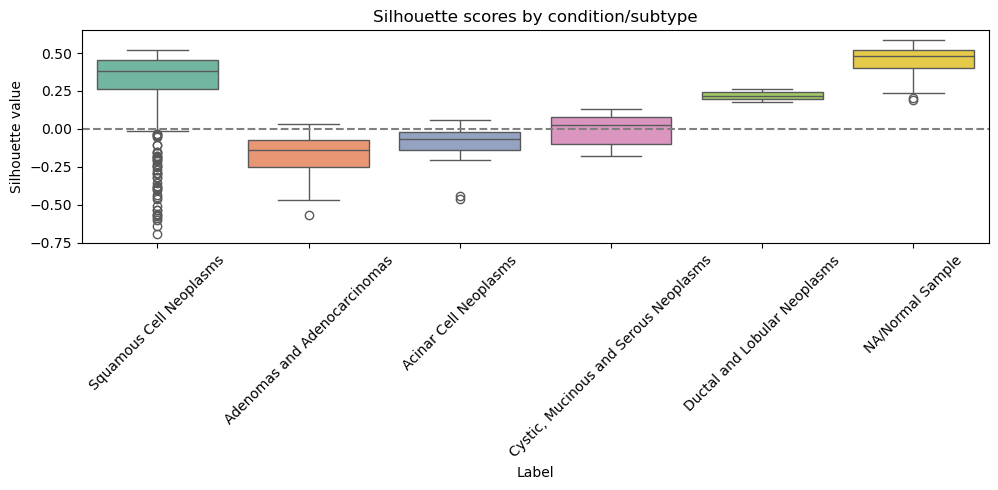

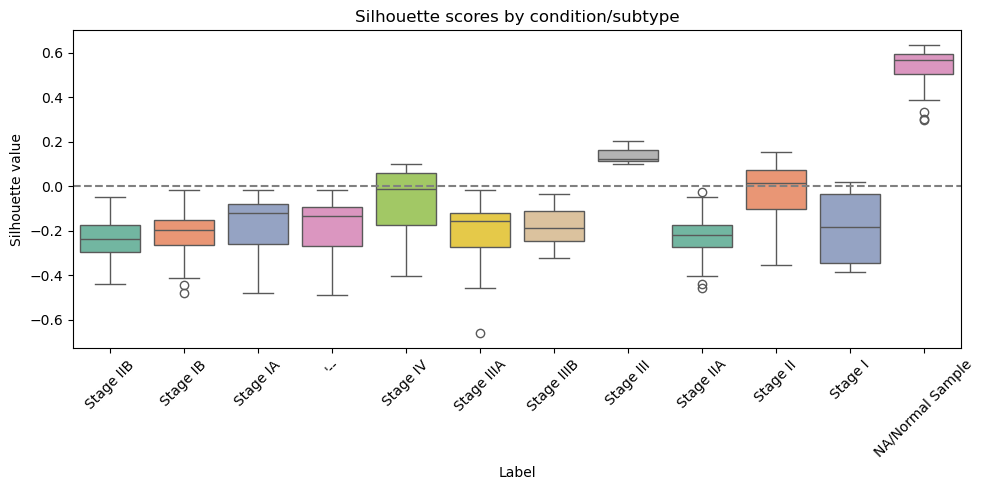

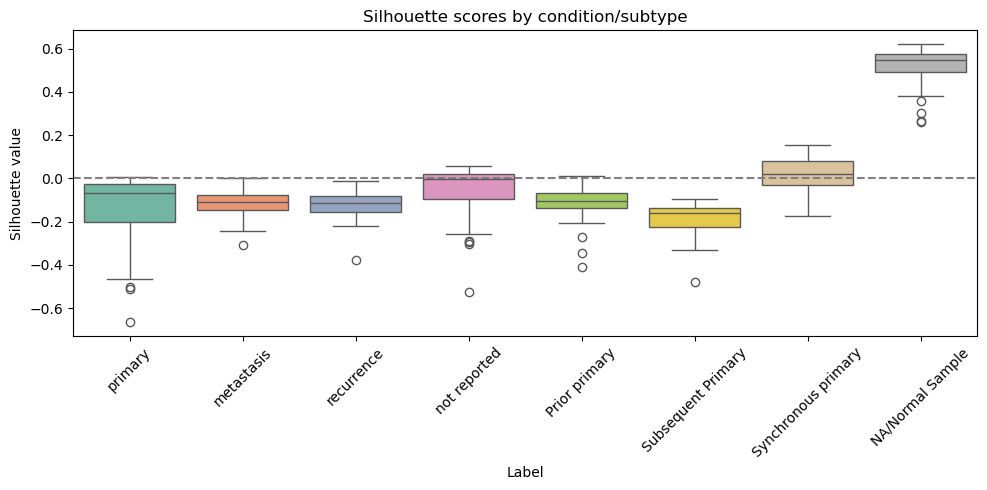

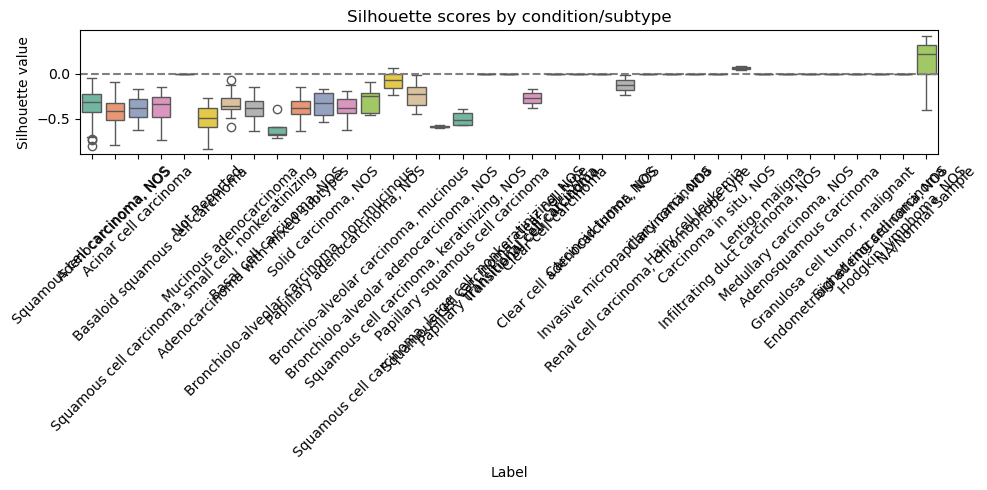

In [145]:
for key in columns_to_group_dict:
    labels = sample_clinical[columns_to_group_dict[key]] 
    sil_values = silhouette_samples(X, labels)
    sil_df = pd.DataFrame({
    'silhouette': sil_values,
    'label': labels.values
    })
    plot_silhouette(sil_df)

In [104]:
X = PCA(n_components=5).fit_transform(log_norm_df)
pcs = pd.DataFrame(X, columns=[f'PC{i+1}' for i in range(5)], index=df_filtered.columns)
metadata = sample_clinical[['demographic.age_at_index', 'demographic.gender', 'demographic.race']].copy()
# Ensure correct dtypes
metadata['demographic.gender'] = metadata['demographic.gender'].astype('category')
metadata['demographic.race'] = metadata['demographic.race'].astype('category')

In [105]:
metadata['Gender'] = metadata['demographic.gender']
metadata['Race']= metadata['demographic.race']
metadata['Age']= metadata['demographic.age_at_index']

In [106]:
df_var = pd.concat([pcs, metadata], axis=1)

In [107]:
results = []
for pc in pcs.columns:
    formula = f"{pc} ~ Age + Gender + Race"
    model = ols(formula, data=df_var).fit()
    r2 = model.rsquared
    results.append({'PC': pc, 'Variance_Explained (%)': round(r2 * 100, 2)})

results_df = pd.DataFrame(results)
print(results_df)

    PC  Variance_Explained (%)
0  PC1                   13.76
1  PC2                    7.21
2  PC3                    7.36
3  PC4                    9.97
4  PC5                    7.36


In [108]:
all_results = []

for pc in pcs.columns:
    formula = f"{pc} ~ Age + Gender + Race"
    model = ols(formula, data=df_var).fit()
    anova_results = anova_lm(model)

    ss_total = anova_results['sum_sq'].sum()
    for idx, row in anova_results.iterrows():
        if idx != 'Residual':
            var_exp = row['sum_sq'] / ss_total * 100
            all_results.append({
                'PC': pc,
                'Variable': idx,
                'Variance_Explained (%)': round(var_exp, 2)
            })

results_df = pd.DataFrame(all_results)
print(results_df)

     PC Variable  Variance_Explained (%)
0   PC1      Age                    5.93
1   PC1   Gender                    6.75
2   PC1     Race                    1.08
3   PC2      Age                    5.57
4   PC2   Gender                    0.56
5   PC2     Race                    1.08
6   PC3      Age                    5.71
7   PC3   Gender                    0.78
8   PC3     Race                    0.86
9   PC4      Age                    8.22
10  PC4   Gender                    0.00
11  PC4     Race                    1.74
12  PC5      Age                    6.63
13  PC5   Gender                    0.29
14  PC5     Race                    0.44


## Subset to DESeq2 Categories

In [169]:
condition = 'Disease Type'

In [45]:
sample_clinical[columns_to_group_dict[condition]]

5faf8a12-a2aa-44f1-b099-02106766ec94         Squamous Cell Neoplasms
6855a406-c085-45c7-b789-981786f0c775    Adenomas and Adenocarcinomas
e2445ad6-2a6a-4ec3-84d8-93cc3c180a58         Squamous Cell Neoplasms
cded92df-9367-4ee5-930c-6c87bf2c8eb0         Squamous Cell Neoplasms
4b167e70-e4e6-47f7-9fe9-11cf20f0d442         Squamous Cell Neoplasms
                                                    ...             
be7b80c8-2256-4725-a330-7435742aa309                NA/Normal Sample
c36f84e5-8c59-46fe-af32-7f70684383b2                NA/Normal Sample
4c994cf9-52d0-4c05-97c0-fd2d3ffb9100                NA/Normal Sample
94613d97-0a68-4212-beef-3c97a0b363ef                NA/Normal Sample
d1f98c65-fd27-4893-a5c5-bc0bfe16ac5f                NA/Normal Sample
Name: cases.disease_type, Length: 1162, dtype: object

In [53]:
metadata_file = f"DESeq2Local/DESeq2Input/lung_{"".join(condition.split(" "))}_Metadata.csv"
condition_counts = sample_clinical[columns_to_group_dict[condition]].copy()
lung_granular_metadata_df = pd.DataFrame(list(condition_counts.items()), columns= ['sample_id', 'condition'])
lung_granular_metadata_df.index = lung_granular_metadata_df['sample_id']
lung_granular_metadata_df = lung_granular_metadata_df.drop('sample_id', axis =1)
lung_granular_metadata_df['condition'] = (
    lung_granular_metadata_df['condition']
    .str.lower()                        # lowercase everything
    .str.replace(r"[ /]", "_", regex=True)  # replace spaces and slashes with underscores
    .str.replace(r"[^a-z0-9_]", "", regex=True)  # remove any other unwanted characters
)
lung_granular_metadata_df

condition
sample_id                                                         
5faf8a12-a2aa-44f1-b099-02106766ec94       squamous_cell_neoplasms
6855a406-c085-45c7-b789-981786f0c775  adenomas_and_adenocarcinomas
e2445ad6-2a6a-4ec3-84d8-93cc3c180a58       squamous_cell_neoplasms
cded92df-9367-4ee5-930c-6c87bf2c8eb0       squamous_cell_neoplasms
4b167e70-e4e6-47f7-9fe9-11cf20f0d442       squamous_cell_neoplasms
...                                                            ...
be7b80c8-2256-4725-a330-7435742aa309              na_normal_sample
c36f84e5-8c59-46fe-af32-7f70684383b2              na_normal_sample
4c994cf9-52d0-4c05-97c0-fd2d3ffb9100              na_normal_sample
94613d97-0a68-4212-beef-3c97a0b363ef              na_normal_sample
d1f98c65-fd27-4893-a5c5-bc0bfe16ac5f              na_normal_sample

[1162 rows x 1 columns]

In [54]:
lung_granular_metadata_df.to_csv(metadata_file)

## Subset samples to train set

In [153]:
subset_count_matrix = pd.read_csv("DESeq2Local/DESeq2Input/subsetted_lung_counts_ml_model.csv")

In [162]:
sample_subset = list(subset_count_matrix.columns)[1:]

In [170]:
metadata_file = f"DESeq2Local/DESeq2Input/lung_subset_{"".join(condition.split(" "))}_Metadata.csv"
condition_counts = sample_clinical[columns_to_group_dict[condition]].copy()
condition_counts = condition_counts.loc[sample_subset]
lung_granular_metadata_df = pd.DataFrame(list(condition_counts.items()), columns= ['sample_id', 'condition'])
lung_granular_metadata_df.index = lung_granular_metadata_df['sample_id']
lung_granular_metadata_df = lung_granular_metadata_df.drop('sample_id', axis =1)
lung_granular_metadata_df['condition'] = (
    lung_granular_metadata_df['condition']
    .str.lower()                        # lowercase everything
    .str.replace(r"[ /]", "_", regex=True)  # replace spaces and slashes with underscores
    .str.replace(r"[^a-z0-9_]", "", regex=True)  # remove any other unwanted characters
)
lung_granular_metadata_df

condition
sample_id                                                         
5faf8a12-a2aa-44f1-b099-02106766ec94       squamous_cell_neoplasms
6855a406-c085-45c7-b789-981786f0c775  adenomas_and_adenocarcinomas
e2445ad6-2a6a-4ec3-84d8-93cc3c180a58       squamous_cell_neoplasms
4b167e70-e4e6-47f7-9fe9-11cf20f0d442       squamous_cell_neoplasms
470afda8-c4a4-4161-b6e7-1f0d2372d2c7       squamous_cell_neoplasms
...                                                            ...
6c20a899-c806-46d0-b744-a26e53a9cb45              na_normal_sample
c36f84e5-8c59-46fe-af32-7f70684383b2              na_normal_sample
4c994cf9-52d0-4c05-97c0-fd2d3ffb9100              na_normal_sample
94613d97-0a68-4212-beef-3c97a0b363ef              na_normal_sample
d1f98c65-fd27-4893-a5c5-bc0bfe16ac5f              na_normal_sample

[894 rows x 1 columns]

In [171]:
lung_granular_metadata_df.to_csv(metadata_file)